# Homework Assignment - Part B


  ###### Dániel László(12305782)     Kishan Parshotam(11635959)      Leonardo Romor(12261734)    
  
* In this notebook we implement the experiment to determine an adequate sample size when testing a new experimental (E) information retrieval system. 

This notebook is split into the following sections:
* Offline
* Interleaving Methods
* Estimating Click Models
* Experiments
* Analysis

In [1]:
# All imports are here
from collections import defaultdict
from collections import namedtuple
from itertools import permutations
import random
import string

from pprint import pprint
from tqdm import tqdm_notebook

import numpy as np
from numpy.random import binomial
from scipy.stats import norm
import matplotlib.pyplot as plt 
from math import sqrt, ceil

## Offline

We start by generating all possible ranking scenarios, and assigning these to their respective buckets. For this we need to first estimate ERR's. 

### ERR Calculation



In [2]:
def calculate_prob_relevance(grade, max_grade=1):
    return (2 ** grade - 1) / (2 ** max_grade)


def calculate_err(ranking_list):
    err = 0
    for r_index, rank in enumerate(ranking_list):
        i_prod = 1
        for i_index in range(r_index):
            i_prod *= (1 - calculate_prob_relevance(ranking_list[i_index]))
        err += 1 / (r_index + 1) * i_prod * calculate_prob_relevance(rank)

    return err


def calculate_delta_err(pair):
    return calculate_err(pair[0]) - calculate_err(pair[1])

### Creating ranking pairs
* Create all possible combinations of relevance for two systems, E and P. 
* Calculate the $\Delta$ERR for every pair.
* Keep only pairs with positive $\Delta$ERR.

In [3]:
def create_positive_pairs(num_labels=2):
    labels = [label for label in range(num_labels)]
    ranks = [(x, y, z) for x in labels for y in labels for z in labels]

    return [(e, p, calculate_delta_err((e, p)))
            for e in ranks
            for p in ranks
            if calculate_delta_err((e, p)) > 0]

### Generating all possible rankings for each of the relevance-pairs
* Now that all possible combinations of ranking have been made, we can generate fake document id's.
* For this we can fix the ranking of one of the systems, and then check all possible scenarios for the other. 
* The filter function only keeps rankings that are unique in their overlappings.
    * For example: (P=[1,2,3]; E=[4,5,6]) and (P=[1,2,3]; E=[5,6,7]) are the same as there are no overlaps in either.
    * If there are any overlapping documents, they must have the same relevance

In [4]:
RankingPair = namedtuple('RankingPair', ['E', 'P', 'rel_E', 'rel_P'])

class RankingPairs:
    def __init__(self, k):
        ''' k: cutoff '''
        self.ranking1 = tuple(range(k))
        all_ids = list(range(2*k))
        self.rankings2 = list(permutations(all_ids, k))
        self.k = k
        self.masks = []

    def filter(self, ranking1, ranking2, relevances1, relevances2):
        # based on the overlaps, mask will have a value, which we compare with previous masks.
        # We only keep the current rankings, if the mask was not seen before.
        # -1 signals no overlap.
        # E.g.: [2, -1, -1] means that the second system's first document
        #                   overlaps with the first system's second document.
        mask = []
        for doc1, rel1 in zip(ranking1, relevances1):
            for doc2, rel2 in zip(ranking2, relevances2):
                if doc1 == doc2 and rel1 != rel2:
                    return False
                elif doc1 == doc2:
                    mask.append(doc1)
                else:
                    mask.append(-1)

        if mask in self.masks:
            return False
        else:
            self.masks.append(mask)
            return True

    def generate_valid_rankings(self, relevance_pair):
        self.masks = []
        rel_B, rel_A = relevance_pair

        if len(rel_A) != self.k or len(rel_B) != self.k:
            raise ValueError(
                'The relevance lists should have a length of {}'.format(self.k))
        else:
            ranking1 = self.ranking1
            valid = [RankingPair(ranking2, ranking1, rel_B, rel_A)
                     for ranking2 in self.rankings2
                     if self.filter(ranking1, ranking2, rel_A, rel_B)]
            return valid


def convert_pairs_of_relevances_to_possible_rankings(pairs):
    k = len(pairs[0][0])
    ranking_pairs = RankingPairs(k)
    result = {tuple(pair): {'rankings': ranking_pairs.generate_valid_rankings(
        pair), 'd_ERR': d_ERR} for *pair, d_ERR in pairs}
    return result

### Creating buckets
* We use the buckets to group the ranking pairs and doc ids.
* Each bucket corresponds to a row in the tables shown in the assignment.

In [5]:
def create_buckets(n_buckets=10, offset=0.05):
    buckets = dict()
    for bucket_id in range(n_buckets):
        buckets[bucket_id] = dict()
        buckets[bucket_id]['range'] = [round(1/10*bucket_id, 2), round(1/n_buckets*(bucket_id + 1), 2)]

    # offset first and last bucket
    buckets[0]['range'][0] = offset
    buckets[n_buckets - 1]['range'][1] -= offset

    return buckets

### Allocating  relevances to buckets
* We take all relevances, and their possible rankings, and allocate them to buckets based on their $\Delta$ERR.
* We only include buckets, that have at least one relevance pairs, deleting redundant ones. Specifically, bucket 8, 9 and 10.

In [6]:
def allocate_to_buckets(relevances, buckets):
    '''
        relevances: Dict[int, RelevancePair]
        buckets: A Dict created by create_buckets()
    '''
    
    for bucket in buckets.values():
        bucket['relevances'] = {}

    for rel_pair, data in relevances.items():
        delta_err = data['d_ERR']
        for bucket in buckets.values():
            interval = bucket['range']
            if interval[0] <= delta_err < interval[1]:
                bucket['relevances'][rel_pair] = data
                break
    
    return delete_empty(buckets)


def delete_empty(buckets):
    buckets_to_delete = []
    for b_id in buckets.keys():
        if not buckets[b_id]['relevances']:
            buckets_to_delete.append(b_id)
    for i in buckets_to_delete:
        del buckets[i]
                
    return buckets


def get_buckets():
    pairs = create_positive_pairs()
    rankings = convert_pairs_of_relevances_to_possible_rankings(pairs)
    buckets = create_buckets()
    allocate_to_buckets(rankings, buckets)
    return buckets

In [7]:
#Test - prints all possible doc_id's combinations for every relevance ranking pair for each bucket. 
pairs = create_positive_pairs()
rankings = convert_pairs_of_relevances_to_possible_rankings(pairs)
buckets = create_buckets()
allocate_to_buckets(rankings, buckets)
pprint(buckets)

{0: {'range': [0.05, 0.1],
     'relevances': {((0, 1, 0), (0, 0, 1)): {'d_ERR': 0.08333333333333334,
                                             'rankings': [RankingPair(E=(0, 2, 1), P=(0, 1, 2), rel_E=(0, 1, 0), rel_P=(0, 0, 1)),
                                                          RankingPair(E=(0, 2, 3), P=(0, 1, 2), rel_E=(0, 1, 0), rel_P=(0, 0, 1)),
                                                          RankingPair(E=(0, 3, 1), P=(0, 1, 2), rel_E=(0, 1, 0), rel_P=(0, 0, 1)),
                                                          RankingPair(E=(0, 3, 4), P=(0, 1, 2), rel_E=(0, 1, 0), rel_P=(0, 0, 1)),
                                                          RankingPair(E=(1, 2, 0), P=(0, 1, 2), rel_E=(0, 1, 0), rel_P=(0, 0, 1)),
                                                          RankingPair(E=(1, 2, 3), P=(0, 1, 2), rel_E=(0, 1, 0), rel_P=(0, 0, 1)),
                                                          RankingPair(E=(1, 3, 0), P=(0, 1, 2), rel_E=(0, 1, 0),

## Interleaving Methods



### Team-Draft Interleaving

In [8]:
def randbit():
    return random.random() > 0.5


class TeamDraftInterleaving:
    def __init__(self, production_ranking, experimental_ranking, k=3):
        self.prod_ranking = list(production_ranking)
        self.exp_ranking = list(experimental_ranking)
        self.k = k   # cutoff

    @staticmethod
    def choose_from_A_and_delete_from_both(A, B, ranking_name):
        '''choose_from_A_and_delete_from_both'''
        doc = A.pop(0)
        try:
            i = B.index(doc)
            del B[i]
        except ValueError:
            pass
            # print('{} : doc {} is not in the other ranking'.format(ranking_name, doc))
        return doc

    def choose_from_prod(self):
        return self.choose_from_A_and_delete_from_both(self.prod_ranking, self.exp_ranking, 'Prod')

    def choose_from_exp(self):
        return self.choose_from_A_and_delete_from_both(self.exp_ranking, self.prod_ranking, 'Exp')

    def run(self):
        '''
            production_ranking = [a_1, a_2, ..., a_n]
            experimental_ranking = [b_1, b_2, ..., b_n]
            where a_i and b_i are document ids
            It is assumed that both rankings contain unique documents, e.g. no duplicates in for the same system
        '''

        interleaved = []  # Interleaved ranking
        TeamA = []
        TeamB = []

        for interleaved_idx in range(len(self.prod_ranking) + len(self.exp_ranking)):
            if len(self.prod_ranking) == 0 and len(self.exp_ranking) == 0:
                break
            
            # We only want the first three documents
            if len(interleaved) == self.k:
                break

            if len(self.exp_ranking) == 0:
                doc = self.choose_from_prod()
                winning_team = TeamA
            elif len(self.prod_ranking) == 0:
                doc = self.choose_from_exp()
                winning_team = TeamB
            elif len(TeamA) < len(TeamB):
                # Chosing from production ranking
                doc = self.choose_from_prod()
                winning_team = TeamA
            elif len(TeamB) < len(TeamA):
                doc = self.choose_from_exp()
                winning_team = TeamB
            else:
                if randbit():
                    doc = self.choose_from_prod()
                    winning_team = TeamA
                else:
                    doc = self.choose_from_exp()
                    winning_team = TeamB

            interleaved.append(doc)
            winning_team.append(doc)

        return interleaved, TeamA, TeamB

In [9]:
# Functions for testing
def generate_docs():
    letters = list(string.ascii_lowercase)
    docs = letters[:6]
    prod_ranking = random.sample(docs, len(docs))
    exp_ranking = random.sample(docs, len(docs))
    print('Ranking P:', prod_ranking)
    print('Ranking E:', exp_ranking)
    return prod_ranking, exp_ranking


def test_team_draft_interleaving(docs=None):
    docs = generate_docs() if docs is None else docs
    prod_ranking, exp_ranking = docs
    team_draft = TeamDraftInterleaving(prod_ranking, exp_ranking)
    interleaved_ranking, prod_docs, exp_docs = team_draft.run()
    print('Rankings Interleaved:', interleaved_ranking)
    print('Docs of P:', prod_docs)
    print('Docs of E:', exp_docs)

### Probabilistic interleaving

In [10]:
def softmax(x):
    e_x = np.exp(x)
    return e_x / np.sum(e_x)


class ProbabilisticInterleaving:
    def __init__(self, prod_ranking, exp_ranking, tau=3, k=3):
        self.prod_ranking = list(prod_ranking)
        self.prod_ranks = list(range(1, len(prod_ranking)+1))

        self.exp_ranking = list(exp_ranking)
        self.exp_ranks = list(range(1, len(exp_ranking)+1))
        self.tau = tau    # Tau is used according to the paper "A Probabilistic Method for Inferring Preferences from Clicks"
        self.k = k
        
        self.update_distributions()

        self.interleaved = []

    def update_distributions(self):
        self.prod_dist = self.probability_dist_over_ranks(self.prod_ranks)
        self.exp_dist = self.probability_dist_over_ranks(self.exp_ranks)

    def probability_dist_over_ranks(self, ranks):
        '''
        Parameters
        ----------
        ranking : list
            A list of documents.
        tau : int
            The second parameter.

        Returns
        -------
        numpy.ndarray
            probability distribution over the given ranking
        '''
        tau = self.tau
        ranks = np.array(ranks)
        inverse_ranks = (1 / ranks) ** tau
        p_dist = softmax(inverse_ranks)
        return p_dist

    def choose_from_A(self, A, p_A, ranks_A, B, p_B, ranks_B, A_name):
        doc = np.random.choice(A, p=p_A)
        i = A.index(doc)
        del A[i]
        del ranks_A[i]

        try:
            i = B.index(doc)
            del B[i]
            del ranks_B[i]
        except ValueError:
            pass
            # print('Doc {} was not in the {} ranking'.format(doc, A_name))

        self.update_distributions()
        return doc

    def choose_from_prod(self):
        doc = self.choose_from_A(self.prod_ranking, self.prod_dist, self.prod_ranks,
                           self.exp_ranking, self.exp_dist, self.exp_ranks, 'Prod')
        return doc

    def choose_from_exp(self):
        doc = self.choose_from_A(self.exp_ranking, self.exp_dist, self.exp_ranks,
                           self.prod_ranking, self.prod_dist, self.prod_ranks, 'Exp')
        return doc

    def run(self):
        '''
            production_ranking = [a_1, a_2, ..., a_n]
            experimental_ranking = [b_1, b_2, ..., b_n]
            where a_i and b_i are document ids
            It is assumed that both rankings contain unique documents
        '''

        interleaved = []  # Interleaved ranking
        TeamA = []
        TeamB = []

        for interleaved_idx in range(len(self.prod_ranking)+len(self.exp_ranking)):
            if len(self.prod_ranking) == 0 and len(self.exp_ranking) == 0:
                break
            
            if len(interleaved) == self.k:
                break
            
            if len(self.exp_ranking) == 0:
                doc = self.choose_from_prod()
                winning_team = TeamA
            elif len(self.prod_ranking) == 0:
                doc = self.choose_from_exp()
                winning_team = TeamB
            elif randbit():
                doc = self.choose_from_prod()
                winning_team = TeamA
            else:
                doc = self.choose_from_exp()
                winning_team = TeamB

            interleaved.append(doc)
            winning_team.append(doc)

        return interleaved, TeamA, TeamB

In [11]:
def test_probabilistic():
    prod_ranking, exp_ranking = generate_docs()
    interleaving = ProbabilisticInterleaving(prod_ranking, exp_ranking)

    interleaved, prod_docs, exp_docs = interleaving.run()

    print('Rankings Interleaved:', interleaved)
    print('Docs of P:', prod_docs)
    print('Docs of E:', exp_docs)

In [12]:
#Test
print('Team-Draft interleaving test:')
test_team_draft_interleaving()
print('\n')
print('Proabilistic interleaving test:')
test_probabilistic()

Team-Draft interleaving test:
Ranking P: ['a', 'c', 'b', 'e', 'f', 'd']
Ranking E: ['c', 'a', 'f', 'e', 'b', 'd']
Rankings Interleaved: ['a', 'c', 'f']
Docs of P: ['a']
Docs of E: ['c', 'f']


Proabilistic interleaving test:
Ranking P: ['c', 'b', 'a', 'd', 'f', 'e']
Ranking E: ['b', 'c', 'd', 'e', 'f', 'a']
Rankings Interleaved: ['b', 'a', 'c']
Docs of P: ['a', 'c']
Docs of E: ['b']


## Estimating Click Models

The goal in this section is to estimate the parameters of two click models:
* Random Click Model
* Position-Based Model

### Parsing the Yandex Log file

In order to estimate the parameters for our click models, we first parse the YandexRelPredChallenge log file. For this we assume that each query is a new session, identified by a unique session_id. Therefore, even repeated queries, under the same SessionID are considered two different session_ids. 

In [13]:
def parse_log_data(log_file):
    '''
    Parser for Yandex log file.
    Outputs two dictionaries: 
        - session_data: ranked ListofURLs and queries information
        - clicks_per_session: URLs clicked for the session
    Outputs are linked via the session_id. 
    '''
    session_data = defaultdict(lambda: defaultdict(list))
    clicks_per_session = defaultdict(list)

    with open(log_file, 'r') as in_file:
        session_id = 0
        for line in in_file:
            line = line.split()
            if line[2] == "C":
                clicks_per_session[session_id-1].append(line[3])    #clicked query_id
            if line[2] == "Q":
                ranked_docs = line[5:]
                rank_count = 0 
                session_data[session_id]['query_id'].append(line[3]) #query id
                for doc in ranked_docs:
                    session_data[session_id]['doc_ids'].append(doc) #doc id
                    rank_count += 1
                session_id += 1

    return session_data, clicks_per_session


def get_session_data_and_clicks_per_session():
    '''
    Calls parse_log_data using YandexRelPredChallenge
    '''
    log_file = "YandexRelPredChallenge.txt"
    session_data, clicks_per_session = parse_log_data(log_file)
    
    return session_data, clicks_per_session

### Random Click Model

We implement the RCM and define three methods, according to the assignment:
* A method that learns the parameters of the model given a set of training data
* A method that predicts the click probability given a ranked list of relevance labels
* A method that decides - stochastically - whether a document is clicked based on these probabilities

In [14]:
class RandomClickModel:
    def __init__(self, session_data, clicks_per_session):
        self.rho = self.estimate_parameters(session_data, clicks_per_session)

    def estimate_parameters(self, session_data, clicks_per_session):
        ndocs = 0
        nclicks = 0
        for id, docs in session_data.items():
            ndocs += len(docs['doc_ids'])
            nclicks += len(clicks_per_session[id])
        return nclicks / ndocs

    def simulate_clicks(self, interleaved_results, *args):
        '''
        Returns idx of clicked document on the interleaved_results list
        '''
        p_click = self.click_probability(interleaved_results)
        clicks = np.array([binomial(1, prob) for prob in p_click])
        return np.where(clicks)[0]
        
    def click_probability(self, interleaved_results):
        click_probabilities = [self.rho for _ in range(len(interleaved_results))]
        return click_probabilities

In [15]:
# TEST
log_file = "YandexRelPredChallenge.txt"
session_data, clicks_per_session = parse_log_data(log_file)
rcm = RandomClickModel(session_data, clicks_per_session)
pprint("Rho: %0.3f" % rcm.rho)

interleaved_test = [1, 2, 3]
print('Click probabilities:', rcm.click_probability(interleaved_test))
print('Click indexes:', rcm.simulate_clicks(interleaved_test))

'Rho: 0.134'
Click probabilities: [0.13445559411047547, 0.13445559411047547, 0.13445559411047547]
Click indexes: []


### Position-Based Model

We implement the PBM and define the same three methods, and some helper ones.

In [16]:
class PositionBasedModel:
    def __init__(self, session_data, clicks_per_session, fixed_alpha = 1e-2):
        self.alphas, self.gammas = self.estimate_parameters(session_data, clicks_per_session)
        self.fixed_alpha = fixed_alpha

    def estimate_alphas(self, alphas, gammas, session_data, clicks_per_session):
        _alphas = defaultdict(lambda: defaultdict(list))

        for session, _ in session_data.items():
            query_id = session_data[session]['query_id'][0]
            for doc_rank, doc in enumerate(session_data[session]['doc_ids']):
                if doc in clicks_per_session[session]:
                    weight = 1
                else:
                    weight = (1 - gammas[doc_rank])*alphas[(query_id, doc)] / (1 - gammas[doc_rank]*alphas[(query_id, doc)])

                _alphas[(query_id, doc)]['weigth'].append(weight)           
                _alphas[(query_id, doc)]['count'].append(1)

        for pair in _alphas.keys():
            sum_weights = sum(_alphas[pair]['weigth']) + 1    # We figured this from pyclick, otherwise gammas converge to 1
            sum_count = sum(_alphas[pair]['count']) + 2
            alphas[pair] = sum_weights / sum_count

        return alphas


    def estimate_gammas(self, alphas, gammas, session_data, clicks_per_session):
        _gammas = defaultdict(lambda: defaultdict(list))

        for session, _ in session_data.items():
            query_id = session_data[session]['query_id'][0]
            for doc_rank, doc in enumerate(session_data[session]['doc_ids']):
                if doc in clicks_per_session[session]:
                    weight = 1
                else:
                    weight = (1 - alphas[(query_id, doc)]) * gammas[doc_rank] / (1 - gammas[doc_rank]*alphas[(query_id, doc)])

                _gammas[doc_rank]['weigth'].append(weight)
                _gammas[doc_rank]['count'].append(1)

        for rank in _gammas.keys():
            sum_weights = sum(_gammas[rank]['weigth']) + 1
            sum_count = sum(_gammas[rank]['count']) + 2
            gammas[rank] = sum_weights / sum_count

        return gammas


    def estimate_parameters(self, session_data, clicks_per_session, num_iterations = 50):
        '''
        EM algorithm. 
        We tested and 50 iterations are sufficient. A convergence criteria could be
        created too by comparing gammas with new gammas and
        taking the difference of the means. 
        '''
        alphas = defaultdict(lambda:np.random.uniform(0.25, 0.75))
        gammas = defaultdict(lambda:np.random.uniform(0.25, 0.75))

        for iteration in tqdm_notebook(range(num_iterations), desc = 'Training PBM'):   
            new_alphas = self.estimate_alphas(alphas, gammas, session_data, clicks_per_session)
            new_gammas = self.estimate_gammas(alphas, gammas, session_data, clicks_per_session)     
            
            alphas = new_alphas
            gammas = new_gammas

        return alphas, gammas


    def simulate_clicks(self, interleaved_results, *args):
        '''
        Simulate clicks according to click_probability
        Returns idx of clicked document on the interleaved_results list
        '''
        p_click = self.click_probability(interleaved_results, args[0])
        clicks = np.array([binomial(1, prob) for prob in p_click])

        return np.where(clicks)[0]


    def click_probability(self, interleaved_results, *args):
        '''
        P(Click = 1) = P(Gamma) * P(alpha -> fixed_alpha if relevance = 0 else 1 - fixed_alpha)
        '''
        p_gammas = np.array([val for val in self.gammas.values()])
        p_gammas = p_gammas[:len(interleaved_results)]
        relevance = args[0]     
        p_alphas = np.array([self.fixed_alpha 
                            if relevance[idx] == 0
                            else 1 - self.fixed_alpha
                            for idx in range(len(interleaved_results))])

        return p_gammas * p_alphas

In [17]:
# Test and output gammmas ~2 minutes
pbm = PositionBasedModel(session_data, clicks_per_session)

for idx, gamma in pbm.gammas.items():
    print('Gamma for rank {}: {}'.format(idx + 1, gamma))


Gamma for rank 1: 0.9949150366925414
Gamma for rank 2: 0.4822943587856462
Gamma for rank 3: 0.33409250560828935
Gamma for rank 4: 0.24640922955392952
Gamma for rank 5: 0.19024940331543205
Gamma for rank 6: 0.15426039902948674
Gamma for rank 7: 0.13617156422811494
Gamma for rank 8: 0.11889217781952965
Gamma for rank 9: 0.10817675116816744
Gamma for rank 10: 0.11311949659917932


In [18]:
# Test
interleaved_results = [2, 0, 3]
relevance = [0, 1, 1]
click_prob = pbm.click_probability(interleaved_results, relevance)
clicks = pbm.simulate_clicks(interleaved_results, relevance)

print('Click probabilities', click_prob)
print('Clicked indexes', clicks)

Click probabilities [0.00994915 0.47747142 0.33075158]
Clicked indexes [1]


## Experiments
In this section we combine all of the code above to run our experiments.
Steps:
* For each interleaving method and click model and we do the following steps:
    * For each bucket:
        * Sample doc_id pairs of size group_size by a bootstrap (with replacement)
        * For each doc_id pair in sampled pairs:
            * Simulate k times:
                1. Do an interleaving of the ranking pairs
                2. Simulate the clicks
                3. Assign the winner based on the clicks
                
We applied bootstrapping to the selection of the pairs to account for skewed $\Delta$ERR distributions within a bucket. See justification from our part A and example in https://demonstrations.wolfram.com/SamplingDistributionOfAPositivelySkewedPopulation/. 

In [19]:
#Setup 
DEBUG = False

session_data, clicks_per_session = get_session_data_and_clicks_per_session()

click_models = {'random': rcm,
                'position-based': pbm}

interleavings = {'probabilistic': ProbabilisticInterleaving,
                 'team-draft': TeamDraftInterleaving}

In [20]:
def sample_from_bucket_generator(bucket, group_size=100):
    ''' Bootstrap sampling '''
    relevances = [i for rel in bucket['relevances'] for i in bucket['relevances'][rel]['rankings']]
    indices = np.arange(len(relevances))
    sampled_indices = np.random.choice(indices, size=group_size, replace=True)
    
    samples = [relevances[i] for i in sampled_indices]
    return samples


def simulate_interleaving_experiment(buckets, interleaving_factory, click_model, n_simulations):
    '''
    Simulates click experiments and stores win results in buckets[id][wins]
    '''
    for bucket in buckets.values():
        wins = {'P': 0, 'E': 0, 'T': 0}
        bucket['wins'] = wins
        samples = sample_from_bucket_generator(bucket)
        for ranking in samples:
            for j in range(n_simulations):
                prod_ranking, exp_ranking = ranking.P, ranking.E
                interleaved, prod_docs, exp_docs = interleaving_factory(
                    prod_ranking, exp_ranking).run()

                relevances = []
                for doc in interleaved:
                    if doc in prod_docs:
                        docs = prod_docs
                        rel = ranking.rel_P
                    else:
                        docs = exp_docs
                        rel = ranking.rel_E

                    i = docs.index(doc)
                    relevances.append(rel[i])

                clicks = click_model.simulate_clicks(interleaved, relevances)

                if DEBUG:
                    print('relevances:', relevances)
                    print(ranking)
                    print('Rankings:', prod_ranking, exp_ranking)
                    print('interleaved:', interleaved)
                    print('prod_docs', prod_docs)
                    print('exp_docs', exp_docs)
                    print('clicks', [interleaved[c] for c in clicks])

                winner = assign_winner(clicks, exp_docs, prod_docs, interleaved)
                if winner == 'E':
                    wins['E'] += 1
                elif winner == 'P':
                    wins['P'] += 1
                else:
                    wins['T'] += 1


def assign_winner(clicks, exp_docs, prod_docs, interleaved):
    ''' Assign a win to the system with the most clicks '''
    click_count_E = 0
    click_count_P = 0

    for click_idx in clicks:
        clicked_doc = interleaved[click_idx]
        if clicked_doc in exp_docs:
            click_count_E += 1
        elif clicked_doc in prod_docs:
            click_count_P += 1

    if click_count_E > click_count_P:
        return 'E'
    elif click_count_P > click_count_E:
        return 'P'
    else:
        return 'T'


def run_click_experiments(k):
    ''' Run the experiments for each click model and interleaving method '''
    results = defaultdict(dict)
    for click_model_name, click_model in click_models.items():
        for interleaving_name, interleaving_factory in interleavings.items():
            buckets = get_buckets()
            simulate_interleaving_experiment(
                buckets, interleaving_factory, click_model, n_simulations=k)

            results[interleaving_name][click_model_name] = \
                {b_id: bucket['wins'] for b_id, bucket in buckets.items()}

    return results

In [21]:
# Test for getting the number of wins after running the click experiment
results = run_click_experiments(1)
pprint(results)

defaultdict(<class 'dict'>,
            {'probabilistic': {'position-based': {0: {'E': 32,
                                                      'P': 18,
                                                      'T': 50},
                                                  1: {'E': 30,
                                                      'P': 11,
                                                      'T': 59},
                                                  2: {'E': 55, 'P': 7, 'T': 38},
                                                  3: {'E': 47, 'P': 8, 'T': 45},
                                                  4: {'E': 68, 'P': 5, 'T': 27},
                                                  5: {'E': 56, 'P': 1, 'T': 43},
                                                  6: {'E': 68,
                                                      'P': 2,
                                                      'T': 30}},
                               'random': {0: {'E': 17, 'P': 18, 'T': 65},
    

### Sample size - Power analysis

In this section, we determine the sample size for multiple iterations in order to get a distribution according to the $\alpha = 0.05$ and $\beta = 0.1$.
* We have discarded ties for calculating the proportions p_1, by defining it as $p_1 = \frac{wins_E}{wins_E + wins_P}$.

In [22]:
def get_sample_size(p_1, p_0=0.5, alpha=0.05, beta=0.1):
    '''
        we set p0 = 0.5 to reflect that each system wins 50% of times.
        p1 is the proportion of times E wins over P out of k simulations.
        α and β specify the level of significance.
            We set α = 0.05 and β = 0.1.
        δ is |p1 − p0|
        z is the standard normal distribution

        Finally, using the continuity correction the minimum sample
        size is determined as:

        Source:
        @inproceedings{azarbonyad2016power,
          title={Power Analysis for Interleaving Experiments by means of Offline Evaluation},
          author={Azarbonyad, Hosein and Kanoulas, Evangelos},
          booktitle={Proceedings of the 2016 ACM International Conference on the Theory of Information Retrieval},
          pages={87--90},
          year={2016},
          organization={ACM}
        }

        See also:
        https://en.wikipedia.org/wiki/Notation_in_probability_and_statistics#Critical_values
    '''

    delta = abs(p_1 - p_0)
    z_alpha = norm.ppf(1-alpha)
    z_beta = norm.ppf(1-beta)
    
    N = (z_alpha * sqrt(p_0*(1-p_0)) + z_beta * sqrt(p_1*(1-p_1)))

    if N == 0.0 or (p_1 - p_0) == 0.0:
        raise ValueError()

    N = N / delta
    N = N**2
    N = N + 1/delta
    return ceil(N)

In [34]:
def nested_defaultdict(depth, inner_factory=list):
    if depth <= 1:
        return defaultdict(list)
    else:
        return defaultdict(lambda: nested_defaultdict(depth-1))
    
def determine_sample_sizes(n, k):
    table = nested_defaultdict(4)
    for i in tqdm_notebook(range(n), desc = 'Running Experiment'):
        results = run_click_experiments(k)

        for interleaving, clicks in results.items():
            for click_model, bucket in clicks.items():
                for b_id, wins in bucket.items():
                    if (wins['E'] + wins['P']) > 0:
                        p_1 = wins['E'] / (wins['E'] + wins['P'])     # proportion of wins
                        try:
                            N = get_sample_size(p_1)
                            table[interleaving][click_model][b_id]['p_1'].append(p_1)
                            table[interleaving][click_model][b_id]['N'].append(N)
                        except ValueError:
                            pass

    return table


def get_final_table(sample_sizes):
    final_table = nested_defaultdict(4)
    plot_data = nested_defaultdict(4)
    for interleaving, clicks in sample_sizes.items():
        for click_model, data in clicks.items():
            for b_id, bucket in data.items():
                final_table[interleaving][click_model][b_id]['min N'] = np.min(
                    bucket['N'])
                final_table[interleaving][click_model][b_id]['median N'] = np.median(
                    bucket['N'])
                final_table[interleaving][click_model][b_id]['max N'] = np.max(
                    bucket['N'])
                plot_data[interleaving][click_model][b_id] = bucket['N']
    return final_table, plot_data


def plot_results(data):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    for interleaving_model, ax_rows in zip(data.items(), axes):
        interleaving_name, inter_data = interleaving_model
        for click_model, axis in zip(inter_data.items(), ax_rows):
            click_name, data = click_model
            x = []
            y = []
            for idx, d in data.items():
                x.append(0.1 * idx + 0.05)
                y.append(np.median(d))
            axis.bar(x, height=y, width=0.05)
            axis.grid()
            axis.set_xlabel(r'$\Delta ERR$')
            axis.set_title("{}, {}".format(interleaving_name, click_name))
    fig.suptitle("Distribution of N over $\Delta ERR$")
    plt.show()
    
def print_final_table(final_table):
    for interleaving in final_table.keys():
        for click_model in final_table[interleaving].keys():
            print('\n')
            print('Interleaving Method: {} - Click Model: {}'.format(interleaving, click_model))
            print('----------| Min |---| Median |---| Max |')
            for b_id, bucket in final_table[interleaving][click_model].items():
                print('bucket{}---| {} |---| {} |---| {} |'.format(b_id+1, bucket['min N'],
                        bucket['median N'], bucket['max N']))
                print('-'*44)

In [38]:
# Run experiments
# Warning: might take some time... 
# n = 20 is sufficient to understand the overall "direction" of the results
sample_sizes = determine_sample_sizes(n=20, k=50)

In [39]:
final_table, plot_data = get_final_table(sample_sizes)
print_final_table(final_table)



Interleaving Method: probabilistic - Click Model: random
----------| Min |---| Median |---| Max |
bucket1---| 2530 |---| 22162.5 |---| 859032 |
--------------------------------------------
bucket2---| 3483 |---| 80182.0 |---| 5759968 |
--------------------------------------------
bucket3---| 1395 |---| 41876.5 |---| 2715597 |
--------------------------------------------
bucket4---| 5586 |---| 34992.0 |---| 5319242 |
--------------------------------------------
bucket5---| 4825 |---| 21898.0 |---| 183975 |
--------------------------------------------
bucket6---| 3381 |---| 17387.0 |---| 2482900 |
--------------------------------------------
bucket7---| 1869 |---| 84904.0 |---| 6087572 |
--------------------------------------------


Interleaving Method: probabilistic - Click Model: position-based
----------| Min |---| Median |---| Max |
bucket1---| 227 |---| 379.0 |---| 636 |
--------------------------------------------
bucket2---| 42 |---| 63.5 |---| 89 |
----------------------------

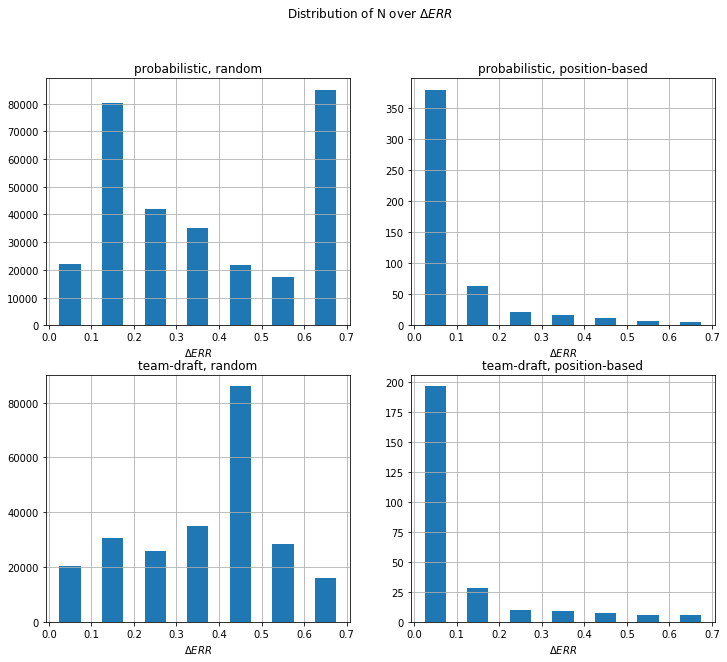

In [40]:
plot_results(plot_data)

## Analysis

### Offline
#### ERR
The ERR is a measure based on the cascade model, meaning that the position of the document is relevant to calculate this metric. 
Of course this is not an optimal measure, since the clicking behavior of a user depends on many other factors. Other measures could have also been evaluated to provide more complete analysis for this experiment.

### Online

### Tables comparison:

##### RCM and PBM:

Regardless of the interleaving method, the random click model acts randomly during the online experiments, contrary to the position-based model. The RCM does not take relevances or order into account and therefore the two systems can perform very similarly, hence to justify systems that have similar performances based on clicks, we need a big sample size. This corresponds to the table results: the random click model's tables have much higher required sample sizes compared to the position-based model's tables. This likely comes from the delta calculation in the power analysis formula, where a smaller delta will mean a larger required sample size. 
The PBM does take the relevances into account, which directly affects the click probability (through $\alpha$). Since we have already filtered pairs of relevances with positive $\Delta$ERR-s, the click probability is higher for System E. Unlike the random click model, in the PBM as we increase the $\Delta$ERR, the required samples get smaller. Intuitively, this makes sense, as a higher $\Delta$ERR means that there was a bigger difference in the systems already in the offline experiments.


##### Team-Draft and Probabilistic interleaving:

The team draft interleaving method is biased in the sense that when we combine the documents from both systems and run this multiple times we will get very similar results, i.e. skewed. However, in the Probabilistic interleaving, we take into account all possible combinations. When we run this multiple times, a position bias disappears since all documents have a probability of being selected. 

The tables show that the robabilistic-interleaving method has higher required samples sizes than the Team-draft. This relates to our point mentioned above that the position bias disappears, and this has an upscale effect on the required sample size since the proportion of wins for system E becomes smaller.


### Downsides from the experiment
Apart from the downsides mentioned above, there are a few more assumptions that were made during designing and running this experiment that do not necessarily reflect a practical use-case. 
* We have only used 2 relevance labels and a ranking of 3. This is a very simplistic approach.
* We assumed that all possible ranking pairs exist. This may not be true in a real system.
* We removed all pairs with a negative relevance. Some pairs might perform better online, namely the ones close to a 0 $\Delta$ERR.


### Future improvements for the experiment
The clicks model that we have used are quite simplistic and do not really model real user behavior. Different, more advanced models could be implemented e.g. Cascade models.

More evaluation measures could be used e.g. DCG.